In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2022-08-23 08:03:46.114773: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.9.1
1.23.2


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

2022-08-23 08:04:23.704625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 08:04:23.872581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 08:04:23.875144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 08:04:23.881626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# basic augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, aug_method=None):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    # cutmix augmentation
    if not is_test and aug_method=='cutmix':
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup augmentation
    elif not is_test and aug_method=='mixup':
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### CutMix

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_label

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### MixUp

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 데이터셋에 augmentation 적용

In [15]:
num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, aug_method='cutmix')
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, aug_method='mixup')

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 모델 만들기

In [16]:
#num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 모델 훈련

In [20]:
# LMS 환경을 기준으로, 모델 학습에 epoch당 2~3분의 시간이 소요됩니다.
# 학습이 너무 오래 걸릴 경우 epoch 수를 조절해 주세요

EPOCH = 20
#EPOCH = 3

위에서 만든 CutMix나 Mixup을 사용하기 위해서는   
앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던  
sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해야 한다.

우리가 cutmix(), mixup()을 구현하면서  
label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다.

#### resnet50

In [22]:
# no augmentation
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 158s 200ms/step - loss: 2.2239 - accuracy: 0.4439 - val_loss: 3.5200 - val_accuracy: 0.1669
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.7766 - accuracy: 0.7822 - val_loss: 1.1146 - val_accuracy: 0.6789
Epoch 3/20
750/750 [==============================] - 158s 210ms/step - loss: 0.2425 - accuracy: 0.9472 - val_loss: 0.9575 - val_accuracy: 0.7212
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0622 - accuracy: 0.9947 - val_loss: 0.8969 - val_accuracy: 0.7431
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0227 - accuracy: 0.9993 - val_loss: 0.9019 - val_accuracy: 0.7422
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0133 - accuracy: 0.9999 - val_loss: 0.9168 - val_accuracy: 0.7457
Epoch 7/20
750/750 [==============================] - 170s 227ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9329 -

#### resnet50 with aug

In [23]:
# basic augmentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 213ms/step - loss: 2.2696 - accuracy: 0.4301 - val_loss: 2.6050 - val_accuracy: 0.3404
Epoch 2/20
750/750 [==============================] - 171s 229ms/step - loss: 0.9347 - accuracy: 0.7304 - val_loss: 1.1290 - val_accuracy: 0.6632
Epoch 3/20
750/750 [==============================] - 159s 211ms/step - loss: 0.4910 - accuracy: 0.8692 - val_loss: 1.0730 - val_accuracy: 0.6883
Epoch 4/20
750/750 [==============================] - 160s 213ms/step - loss: 0.2403 - accuracy: 0.9472 - val_loss: 1.1478 - val_accuracy: 0.6777
Epoch 5/20
750/750 [==============================] - 160s 213ms/step - loss: 0.1214 - accuracy: 0.9793 - val_loss: 1.0525 - val_accuracy: 0.7086
Epoch 6/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0721 - accuracy: 0.9908 - val_loss: 1.0272 - val_accuracy: 0.7192
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0431 - accuracy: 0.9958 - val_loss: 0.9436 -

#### resnet50 with cutmix

In [24]:
# basic augmentation + cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 168s 214ms/step - loss: 3.8804 - accuracy: 0.2025 - val_loss: 3.1910 - val_accuracy: 0.2289
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 3.0463 - accuracy: 0.4043 - val_loss: 1.5264 - val_accuracy: 0.5810
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 2.7563 - accuracy: 0.4991 - val_loss: 1.3981 - val_accuracy: 0.6171
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 2.5916 - accuracy: 0.5394 - val_loss: 1.4162 - val_accuracy: 0.6192
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 2.4403 - accuracy: 0.5874 - val_loss: 1.2803 - val_accuracy: 0.6454
Epoch 6/20
750/750 [==============================] - 159s 211ms/step - loss: 2.3296 - accuracy: 0.6270 - val_loss: 1.3364 - val_accuracy: 0.6315
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.2439 - accuracy: 0.6497 - val_loss: 1.2132 -

#### resnet50 with mixup

In [25]:
# basic augmentation + mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 214ms/step - loss: 3.7883 - accuracy: 0.2240 - val_loss: 3.8454 - val_accuracy: 0.1335
Epoch 2/20
750/750 [==============================] - 159s 212ms/step - loss: 2.9303 - accuracy: 0.4493 - val_loss: 1.5351 - val_accuracy: 0.5736
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.6866 - accuracy: 0.5392 - val_loss: 1.4684 - val_accuracy: 0.5949
Epoch 4/20
750/750 [==============================] - 159s 211ms/step - loss: 2.5302 - accuracy: 0.5986 - val_loss: 1.4632 - val_accuracy: 0.5970
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 2.3884 - accuracy: 0.6521 - val_loss: 1.2505 - val_accuracy: 0.6515
Epoch 6/20
750/750 [==============================] - 159s 211ms/step - loss: 2.3071 - accuracy: 0.6869 - val_loss: 1.2880 - val_accuracy: 0.6426
Epoch 7/20
750/750 [==============================] - 159s 211ms/step - loss: 2.2191 - accuracy: 0.7198 - val_loss: 1.1212 -

### 훈련 결과 시각화

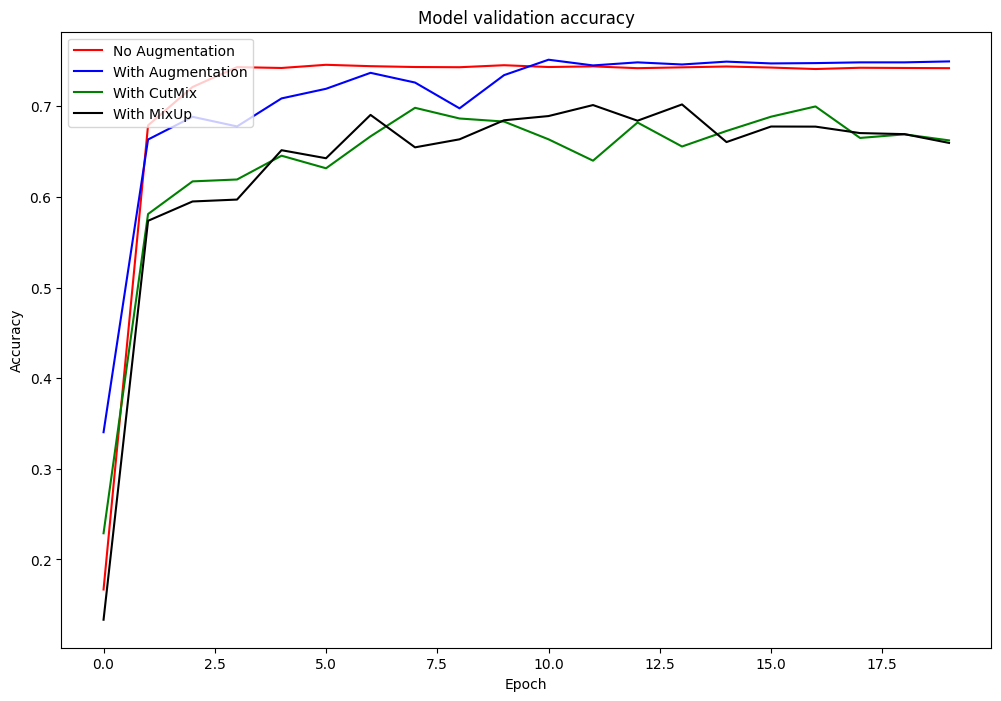

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix.history['val_accuracy'], 'g')
plt.plot(history_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()